<a href="https://colab.research.google.com/github/bhushanrajs/sciml_project/blob/main/project_PySR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Symbolic Regression

In [33]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.8.5"
export JULIA_PKG_PRECOMPILE_AUTO=0
#---------------------------------------------------#

if [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  echo "Installing PyCall.jl..."
  julia -e 'using Pkg; Pkg.add("PyCall"); Pkg.build("PyCall")'
  julia -e 'println("Success")'

fi

Install PySR and PyTorch-Lightning:

In [34]:
%pip install -Uq pysr pytorch_lightning --quiet

In [35]:
from julia import Julia

julia = Julia(compiled_modules=False, threads="auto")
from julia import Main
from julia.tools import redirect_output_streams

redirect_output_streams()

In [36]:
import pysr

# We don't precompile in colab because compiled modules are incompatible static Python libraries:
pysr.install(precompile=False)

Julia Version 1.8.5
Commit 17cfb8e65ea (2023-01-08 06:45 UTC)
Platform Info:
  OS: Linux (x86_64-linux-gnu)
      Ubuntu 22.04.3 LTS
  uname: Linux 5.15.120+ #1 SMP Wed Aug 30 11:19:59 UTC 2023 x86_64 x86_64
  CPU: Intel(R) Xeon(R) CPU @ 2.20GHz: 
              speed         user         nice          sys         idle          irq
       #1  2199 MHz      17032 s          0 s       2001 s      64051 s          0 s
       #2  2199 MHz      17462 s          0 s       1997 s      63622 s          0 s
  Memory: 12.678337097167969 GB (10687.45703125 MB free)
  Uptime: 8341.71 sec
  Load Avg:  1.09  0.42  0.27
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-13.0.1 (ORCJIT, broadwell)
  Threads: 1 on 2 virtual cores
Environment:
  LD_LIBRARY_PATH = /usr/lib64-nvidia
  JULIA_PROJECT = @pysr-0.16.3
  JULIA_PKG_PRECOMPILE_AUTO = 0
  TCLLIBPATH = /usr/share/tcltk/tcllib1.20
  HOME = /root
  PYTHONPATH = /env/python
  LIBRARY_PATH = /usr/local/cuda/lib64/stubs
  PATH = /opt/bin:/usr/local/nvid

[ Info: Julia version info
[ Info: Julia executable: /usr/local/bin/julia
[ Info: Trying to import PyCall...
┌ Info: PyCall is already installed and compatible with Python executable.
│ 
│ PyCall:
│     python: /usr/bin/python3
│     libpython: /usr/lib/x86_64-linux-gnu/libpython3.10.so.1.0
│ Python:
│     python: /usr/bin/python3
└     libpython: 
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
/usr/local/lib/python3.10/dist-packages/pysr/julia_helpers.py:118: UserWarning: It is recommended to restart Python after installing PySR's dependencies, so that the Julia environment is properly initialized.
  warnings.warn(


In [37]:
import sympy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pysr import PySRRegressor
from sklearn.model_selection import train_test_split

In [38]:
df = pd.read_csv('https://raw.githubusercontent.com/bhushanrajs/sciml_project/main/analysis_data.csv')

tx_girders = {'Tx28' : {'D' : 28.0, 'b1' : 36.0, 'b2' : 7.0, 'b3' : 32.0, 'b4' : 2.0, 'b5' : 3.0, 'd1' : 3.5, 'd2' : 2.0, 'd3' : 2.0, 'd4' : 6.75, 'd5' : 3.0, 'd6' : 4.0, 'd7' : 6.75},
              'Tx34' : {'D' : 34.0, 'b1' : 36.0, 'b2' : 7.0, 'b3' : 32.0, 'b4' : 2.0, 'b5' : 3.0, 'd1' : 3.5, 'd2' : 2.0, 'd3' : 2.0, 'd4' : 12.75, 'd5' : 3.0, 'd6' : 4.0, 'd7' : 6.75},
              'Tx40' : {'D' : 40.0, 'b1' : 36.0, 'b2' : 7.0, 'b3' : 32.0, 'b4' : 2.0, 'b5' : 3.0, 'd1' : 3.5, 'd2' : 2.0, 'd3' : 2.0, 'd4' : 18.75, 'd5' : 3.0, 'd6' : 4.0, 'd7' : 6.75},
              'Tx46' : {'D' : 46.0, 'b1' : 36.0, 'b2' : 7.0, 'b3' : 32.0, 'b4' : 2.0, 'b5' : 3.0, 'd1' : 3.5, 'd2' : 2.0, 'd3' : 2.0, 'd4' : 22.0, 'd5' : 3.0, 'd6' : 4.75, 'd7' : 8.75},
              'Tx54' : {'D' : 54.0, 'b1' : 36.0, 'b2' : 7.0, 'b3' : 32.0, 'b4' : 2.0, 'b5' : 3.0, 'd1' : 3.5, 'd2' : 2.0, 'd3' : 2.0, 'd4' : 30.0, 'd5' : 3.0, 'd6' : 4.75, 'd7' : 8.75},
              'Tx62' : {'D' : 62.0, 'b1' : 42.0, 'b2' : 7.0, 'b3' : 32.0, 'b4' : 2.0, 'b5' : 3.0, 'd1' : 3.5, 'd2' : 2.5, 'd3' : 2.0, 'd4' : 37.5, 'd5' : 3.0, 'd6' : 4.75, 'd7' : 8.75},
              'Tx70' : {'D' : 70.0, 'b1' : 42.0, 'b2' : 7.0, 'b3' : 32.0, 'b4' : 2.0, 'b5' : 3.0, 'd1' : 3.5, 'd2' : 2.5, 'd3' : 2.0, 'd4' : 45.5, 'd5' : 3.0, 'd6' : 4.75, 'd7' : 8.75},
              'Tx84' : {'D' : 84.0, 'b1' : 58.0, 'b2' : 8.0, 'b3' : 38.0, 'b4' : 3.0, 'b5' : 3.0, 'd1' : 4.0, 'd2' : 3.5, 'd3' : 3.0, 'd4' : 55.75, 'd5' : 3.0, 'd6' : 6.0, 'd7' : 8.75}
              }

# bridge geometry data
L = df['L']/12 # span length in ft.
S = df['S']/12 # girder spacing in ft.
w_oh = df['w_oh']/12 # overhang width in ft.
ts = df['ts_U']/12 # thickness of overhang in ft.
girder = df['Girder Type']
D = []
for _, girder_type in girder.items():
  D.append(tx_girders[girder_type]['D'])
df['D'] = D

# intensity of railing dead load in kip/ft
b_rail = df['b_rail_left'] # width of railing
q_rail = (df['q_rail_left'] * b_rail * 12)/1000

# max bending moment in exterior girder G1 & interior girder G2 in kip-ft
bm1 = df['G1 - max_bm']/(1000*12)
bm2 = df['G2 - max_bm']/(1000*12)
bm3 = df['G3 - max_bm']/(1000*12)
bm4 = df['G4 - max_bm']/(1000*12)

# reaction in girders G1 & G2 in kip. (only A1 taken due to symmetry)
r1 = df['G1-A1-Y']/1000
r2 = df['G2-A1-Y']/1000
r3 = df['G3-A1-Y']/1000
r4 = df['G4-A1-Y']/1000

# line analysis with full railing load assumed to be applied on a girder
bm_line = q_rail * (L - 2*9/12)**2 / 8
r_line = q_rail * L / 2


# normalizing bending moments with respect to line analysis
n_bm1 = bm1 / bm_line
n_bm2 = bm2 / bm_line
n_bm3 = bm3 / bm_line
n_bm4 = bm4 / bm_line

# normalizing vertical reactions with respect to line analysis
n_r1 = r1 / r_line
n_r2 = r2 / r_line
n_r3 = r3 / r_line
n_r4 = r4 / r_line

# add the distribution factors to the dataframe
df['n_bm1'] = n_bm1
df['n_bm2'] = n_bm2
df['n_bm3'] = n_bm3
df['n_bm4'] = n_bm4
df['n_r1'] = n_r1
df['n_r2'] = n_r2
df['n_r3'] = n_r3
df['n_r4'] = n_r4

In [39]:
# sample data from leve rule
# n_r1 = (w_oh + S) / S

In [40]:
X = np.stack((L, w_oh, S, D), axis=-1)
y = n_r1

In [41]:
# Learn equations
default_pysr_params = dict(
    populations=30,
    model_selection="best",
)

# model = PySRRegressor(
#     niterations=30,
#     binary_operators=['+', '-', '*', '/', '^'],
#     unary_operators=["square", "cube", "sqrt"],
#     **default_pysr_params
# )

model = PySRRegressor(
    niterations=50,  # < Increase me for better results
    binary_operators=['+', '-', '*', '/', '^', "physics(x, y) = x^2 / y"],
    unary_operators=["square", "cube", "sqrt", "inv(x) = 1/x"],
        # ^ Custom operator (julia syntax)
    extra_sympy_mappings={"inv": lambda x: 1 / x,
                          "physics": lambda x, y: x**2 / y},
    # ^ Define operator for SymPy as well
    loss="loss(prediction, target) = (prediction - target)^2",
    # ^ Custom loss function (julia syntax)
    **default_pysr_params
)

model.fit(X, y)

print(model)

/usr/local/lib/python3.10/dist-packages/pysr/sr.py:1346: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pysr/julia_helpers.py:231: UserWarning: Julia has already started. The new Julia options {'threads': 2} will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pysr/sr.py:109: UserWarning: You are using the `^` operator, but have not set up `constraints` for it. This may lead to overly complex expressions. One typical constraint is to use `constraints={..., '^': (-1, 1)}`, which will allow arbitrary-complexity base (-1) but only powers such as a constant or variable (1). For more tips, please see https://astroautomata.com/PySR/tuning/
  warnings.warn(


Started!

Expressions evaluated per second: 5.360e+02
Head worker occupation: 1.1%
Progress: 3 / 1500 total iterations (0.200%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           1.472e-02  1.594e+01  y = 1.078
3           6.017e-03  4.474e-01  y = (0.67315 ^ 0.039047)
6           2.315e-03  3.183e-01  y = sqrt(sqrt(x₁) / square(1.2626))
11          2.083e-03  2.117e-02  y = square(((x₀ ^ (square(0.82432) / x₁)) / x₁) ^ -0.048705)
14          1.906e-03  2.959e-02  y = (physics(sqrt(physics(x₀ ^ (0.82432 / x₁), x₃ ^ 0.42847)),...
                                   x₁) ^ -0.048705)
16          1.905e-03  1.460e-04  y = ((physics(sqrt(physics(x₀ ^ ((x₂ ^ 0.074687) / x₁), x₃)), ...
                                  1.078) * 0.92284) ^ -0.048705)
18          1.725e-03  4.972e-02  y = (physics(sqrt(physics(x₀ ^ ((sqrt(x₃) ^ 0.074687) / x₁), x...
                               

In [42]:
model.sympy()

((sqrt(x0) + x0 - x3)/(1.4716514*x1**3 + x2))**(-0.1082854)

In [43]:
n_r1_pred = model.predict(X)

print("Default selection MSE:", np.power(n_r1_pred - y, 2).mean())

Default selection MSE: 0.00013255379389133558


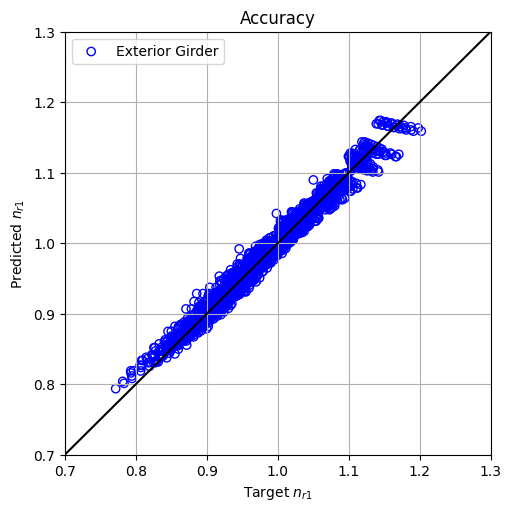

In [44]:
x_line = [0.5, 1.5]
y_line = [0.5, 1.5]

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), constrained_layout = True)

ax1.scatter(x=n_r1, y=n_r1_pred, marker='o', c='none', edgecolor='b', label='Exterior Girder')
ax1.plot(x_line, y_line, c = "k")
ax1.set_title('Accuracy')
ax1.legend()
plt.xlim((0.7,1.3))
plt.ylim((0.7,1.3))
ax1.set_xlabel('Target $n_{r1}$')
ax1.set_ylabel('Predicted $n_{r1}$')
ax1.grid()

In [45]:
model.latex()

'\\left(\\frac{\\sqrt{x_{0}} + x_{0} - x_{3}}{1.47 x_{1}^{3} + x_{2}}\\right)^{-0.108}'

$0.757 + \frac{1}{\sqrt{\frac{x_{0}^{2}}{x_{1}^{2} x_{3}}}}$

$0.757 + \frac{w_{oh} D^{0.5}}{L}$

In [46]:
y2 = n_r2

model.fit(X, y2)

print(model)


/usr/local/lib/python3.10/dist-packages/pysr/sr.py:1886: UserWarning: The discovered expressions are being reset. Please set `warm_start=True` if you wish to continue to start a search where you left off.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pysr/sr.py:1346: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pysr/julia_helpers.py:231: UserWarning: Julia has already started. The new Julia options {'threads': 2} will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pysr/sr.py:109: UserWarning: You are using the `^` operator, but have not set up `constraints` for it. This may lead to overly complex expressions. One typical constraint is to use `constraints={..., '^': (-1, 1)}`, which will allow arbitrary-complexity base (-1) but only powers such as a constant or variable (1). For more tips, please see https://astroautomata.com/PySR/tuning/
  warni

Started!

Expressions evaluated per second: 6.900e+03
Head worker occupation: 0.3%
Progress: 16 / 1500 total iterations (1.067%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           6.203e-03  1.594e+01  y = -9.1418e-05
2           4.863e-03  2.434e-01  y = inv(x₃)
4           4.491e-03  3.978e-02  y = inv(square(square(2.2653)))
5           3.029e-03  3.939e-01  y = inv(2.2653 + cube(x₁))
6           2.327e-03  2.637e-01  y = inv(square(2.2653) + cube(x₁))
7           2.139e-03  8.415e-02  y = (((x₁ ^ x₁) + 1.8752) ^ -1.3952)
9           2.100e-03  9.233e-03  y = inv((cube(x₁) + sqrt(x₂)) * sqrt(x₁))
10          1.881e-03  1.103e-01  y = (((inv(x₁) + (x₁ ^ x₁)) + 1.8752) ^ -1.3952)
14          1.880e-03  5.873e-05  y = (((inv(sqrt(cube(x₁) + -0.6576)) + (x₁ ^ x₁)) + 1.8752) ^ ...
                                  -1.3952)
15          1.291e-03  3.762e-01  y = ((((physics(

In [47]:
model.sympy()

(-0.74106324 + x1**2/x0)**6 - x1**2*x3**2/x0**3

In [48]:
n_r2_pred = model.predict(X)

print("Default selection MSE:", np.power(n_r2_pred - y2, 2).mean())

Default selection MSE: 0.00022245335746704246


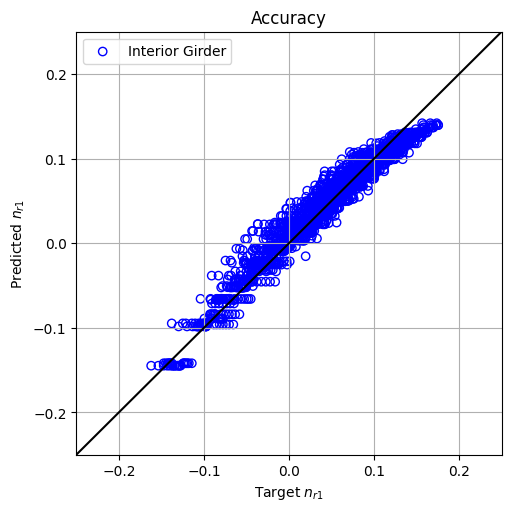

In [49]:
x_line = [-0.25, 0.25]
y_line = [-0.25, 0.25]

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), constrained_layout = True)

ax1.scatter(x=n_r2, y=n_r2_pred, marker='o', c='none', edgecolor='b', label='Interior Girder')
ax1.plot(x_line, y_line, c = "k")
ax1.set_title('Accuracy')
ax1.legend()
plt.xlim((-0.25, 0.25))
plt.ylim((-0.25, 0.25))
ax1.set_xlabel('Target $n_{r1}$')
ax1.set_ylabel('Predicted $n_{r1}$')
ax1.grid()

In [50]:
model.latex()

'\\left(-0.741 + \\frac{x_{1}^{2}}{x_{0}}\\right)^{6} - \\frac{x_{1}^{2} x_{3}^{2}}{x_{0}^{3}}'

$ \frac{x_{1}^{2}}{x_{0} - \frac{x_{3}}{x_{1}}} + 0.167 $

$ \frac{w_{oh}^{2}}{L - \frac{D}{w_{oh}}} + 0.167 $